In [1]:
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from unidip import UniDip
import unidip.dip as dip

In [2]:
pd_train = pd.read_csv('../data/train.csv')
pd_train.shape

(2834, 6)

## DIP test hypothesis H0:uni-modal vs H1:not uni-modal
## UniDip returns list of tuples: each tuple containing the start and end indecies of the distribution

In [3]:
def test_modality(values):
    data = np.msort(values)
    res1 = dip.diptst(data)
    res2 = UniDip(data).run()
    return (res1, res2)

In [4]:
# Create segments between 5 and 15

def create_segments(total_bins, bin_len):
    bins = [(0, bin_len)]
    for seg in range(total_bins-1):
        if seg == total_bins-2:
            bins.append((bins[-1][1], np.nan))
        else:
            bins.append((bins[-1][1], bins[-1][1]+bin_len))
    return bins

def create_bins(df, column, num_of_bins=5):
    bin_len = int(len(df)/num_of_bins)
    bins = create_segments(num_of_bins, bin_len)
    df = df.sort_values(column, ascending=True).reset_index(drop=True)
    column_name = column+"_segment"
    df[column_name] = 0
    for index, seg in enumerate(bins):
        start = seg[0]
        end = seg[1]
        if end is not np.nan:
            df.loc[start:end, column_name] = str(index)
        else:
            df.loc[start:, column_name] = str(index)
    return df

In [5]:
# number of bins are selected by dip analysis
# 4 bins gives the lowest neutral samples a.k.a error
# error: the samples cannot be placed in either group [B1 or B2] they are in the middle between two modals (end index of modal1 - start index of modal2)

bins = 4
pd_train = create_bins(copy.deepcopy(pd_train), "standard_error", bins)

In [6]:
for i in range(bins):
    print(test_modality(pd_train.loc[pd_train['standard_error_segment'] == str(i), 'target'].values))

((0.008345022480293757, 0.994005994005994, (318, 521)), [(0, 707)])
((0.010866187695802498, 0.9040959040959041, (353, 522)), [(0, 707)])
((0.013514101436162856, 0.5654345654345654, (411, 652)), [(0, 707)])
((0.073977641474886, 0.000999000999000999, (22, 328)), [(22, 327), (443, 679)])


Text(0, 0.5, 'Frequency')

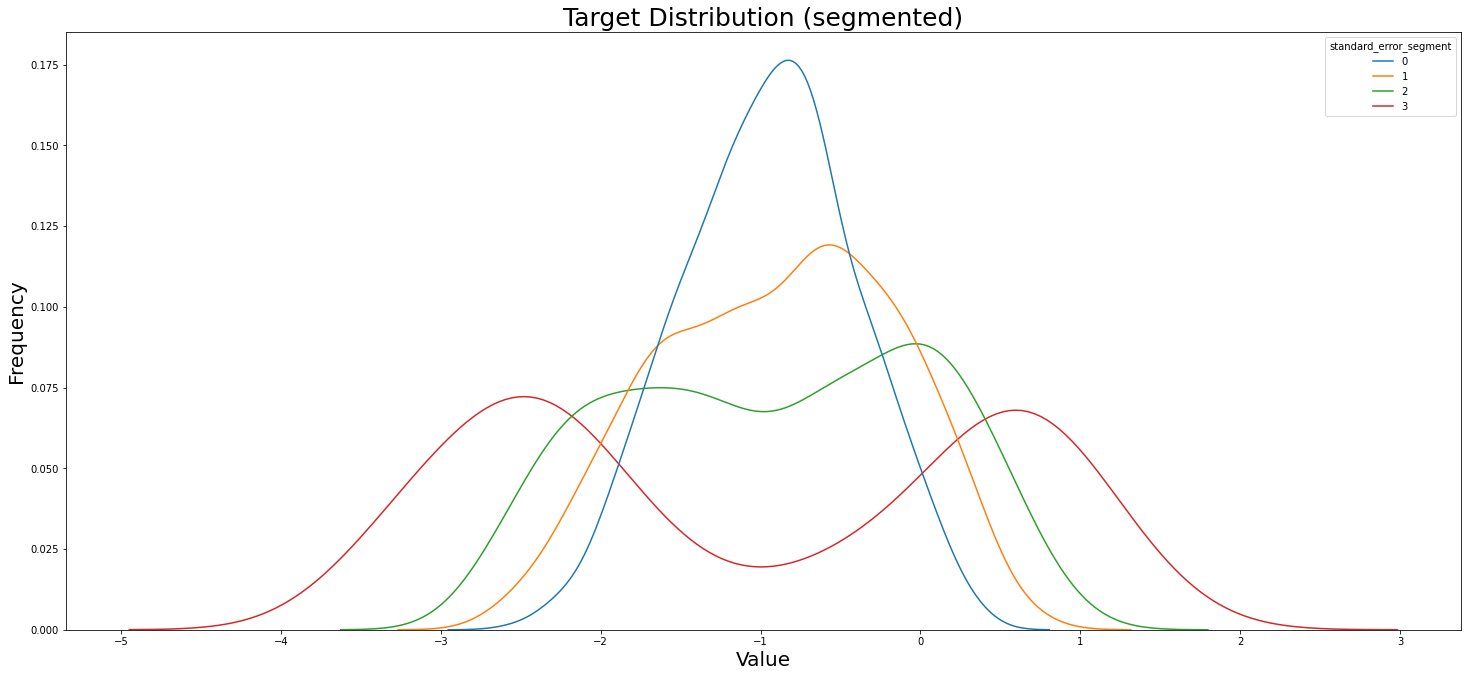

In [7]:
plt.figure(figsize = (25, 11))
sns.kdeplot(pd_train["target"], hue=pd_train["standard_error_segment"])
plt.title("Target Distribution (segmented)", size=25)
plt.xlabel("Value", size=20)
plt.ylabel("Frequency", size=20)

## Let us look at the neutral samples

In [8]:
bi_modal_1 = pd_train.loc[pd_train['standard_error_segment'] == str(3)].sort_values(by='target').reset_index(drop=True)

In [9]:
# Everything upto 327 is in B1 and everythong from 443 is B2
# Let us see how we will assign B1 or B2 for lables between 327 and 443

test_modality(bi_modal_1.iloc[327:443]['target'].values)

((0.06001980224650505, 0.003996003996003996, (54, 110)), [(2, 37), (54, 109)])

## The Dip test is not significant, the data is unimodal. Divide them at the center and assign the first half to B1 and second half to B2

## generating class_labels map based on the bins. We will use target as key because they are unique for every row.
### If not for target we would have had to introduced a id column in clenaing_and_adding_new_samples_using_translate.py and use that id column here.

In [11]:
G_keys = pd_train.loc[(pd_train['standard_error_segment'] == '0') | (pd_train['standard_error_segment'] == '1') | (pd_train['standard_error_segment'] == '2'), 'target'].values
B0_keys = bi_modal_1[:355]['target'].values
B1_keys = bi_modal_1[355:]['target'].values

In [12]:
len(G_keys)+len(B0_keys)+len(B1_keys) == pd_train.shape[0]

True

In [13]:
def assign_dev_1_labels(row):
    if row['target'] in G_keys:
        return 'G'
    else: return 'B'

pd_train['dev_1'] = pd_train.apply(lambda row: assign_dev_1_labels(row), axis=1)

pd_train.value_counts(['dev_1'], normalize=True)

dev_1
G        0.749471
B        0.250529
dtype: float64

In [14]:
def assign_dev_2_labels(row):
    if row['target'] in G_keys:
        return 'G'
    elif row['target'] in B0_keys:
        return 'B0'
    else: return 'B1'

pd_train['dev_2'] = pd_train.apply(lambda row: assign_dev_2_labels(row), axis=1)

pd_train.value_counts(['dev_2'], normalize=True)

dev_2
G        0.749471
B0       0.125265
B1       0.125265
dtype: float64

In [15]:
train = pd.read_csv('../data/new_preprocessed_train_data.csv', low_memory=False)

In [16]:
def assign_dev_1_labels_for_dup(row):
    if row['labels'] in G_keys:
        return 'G'
    else: return 'B'

train['dev_1'] = train.apply(lambda row: assign_dev_1_labels_for_dup(row), axis=1)

train.value_counts(['dev_1'], normalize=True)

dev_1
G        0.749471
B        0.250529
dtype: float64

In [17]:
def assign_dev_2_labels_for_dup(row):
    if row['labels'] in G_keys:
        return 'G'
    elif row['labels'] in B0_keys:
        return 'B0'
    else: return 'B1'

train['dev_2'] = train.apply(lambda row: assign_dev_2_labels_for_dup(row), axis=1)

train.value_counts(['dev_2'], normalize=True)

dev_2
G        0.749471
B0       0.125265
B1       0.125265
dtype: float64

In [18]:
train.loc[train['dev_2'] == 'G'].describe().T

,count,mean,std,min,25%,50%,75%,max
se,12744.0,0.476119,0.019348,0.000000,0.464098,0.476296,0.489793,0.506137
labels,12744.0,-0.916897,0.766500,-2.846767,-1.486255,-0.885636,-0.346327,1.019009


In [19]:
train.loc[train['dev_2'] == 'B0'].describe().T

,count,mean,std,min,25%,50%,75%,max
se,2130.0,0.539778,0.032090,0.506304,0.516170,0.528028,0.554081,0.649671
labels,2130.0,-2.544082,0.516202,-3.676268,-2.913002,-2.500836,-2.165763,-1.499108


In [20]:
train.loc[train['dev_2'] == 'B1'].describe().T

,count,mean,std,min,25%,50%,75%,max
se,2130.0,0.534729,0.028123,0.506161,0.513557,0.526324,0.547307,0.648474
labels,2130.0,0.371631,0.671195,-1.492649,0.022598,0.498430,0.851171,1.711390


In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
se,17004.0,0.491435,0.034813,0.000000,0.468540,0.484721,0.506304,0.649671
labels,17004.0,-0.959319,1.033427,-3.676268,-1.691501,-0.912190,-0.202360,1.711390


In [22]:
train.to_csv('../data/classifier_training_data/raw_data.csv', index=False)